In [9]:
import pandas as pd
from utils import *
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import os
from scipy.signal import savgol_filter
import scipy
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [10]:
# import required module

# assign directory
directory = 'data/5deg_350motor'
smoothing = True
calibrate = True
if calibrate:
    calib = pd.read_csv('data/calibration.csv').drop('timestamp', axis=1).mean()

sensor_col=[f'sensor_{i}' for i in range(1,7)]

experiments = {}
# that directory
for filename in os.listdir(directory):
    if filename[-3:] == 'csv':
        if 'extended' in filename:
            f = os.path.join(directory, filename)
            experiments[filename] = pd.read_csv(f)
            experiments[filename]['experiment'] = 'extended'
            experiments[filename]['experiment_id'] = int(filename[filename.find('_')+1])

        if 'folding' in filename:
            f = os.path.join(directory, filename)
            experiments[filename] = pd.read_csv(f)
            experiments[filename]['experiment'] = 'folding'
            experiments[filename]['experiment_id'] = int(filename[filename.find('_')+1])
        if smoothing:
            y = experiments[filename][[f'sensor_{i}' for i in range(1,7)]]
            experiments[filename][[f'sensor_{i}' for i in range(1,7)]] = savgol_filter(y, 10, 3, axis=0)
        if calibrate:
            experiments[filename][sensor_col] = experiments[filename][sensor_col] - calib
        experiments[filename][sensor_col] = experiments[filename][sensor_col]*scipy.constants.g # Convert to newtons
        experiments[filename]['lift'] = experiments[filename]['sensor_4'] + experiments[filename]['sensor_5'] + experiments[filename]['sensor_6']

        experiments[filename]['thrust'] = experiments[filename]['sensor_2'] + experiments[filename]['sensor_3'] - experiments[filename]['sensor_1']


df = pd.concat([experiments[exp] for exp in experiments], ignore_index=True)

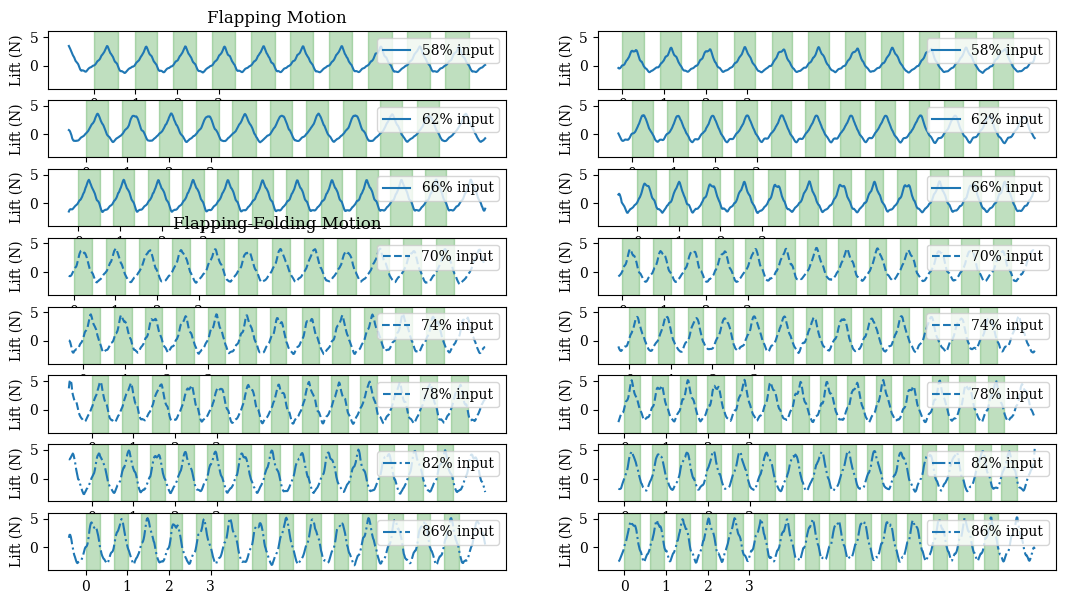

In [51]:
from matplotlib.patches import Rectangle
start_search = {
    1:[4,4.4],
    2:[4.5, 4.4],
    3:[4.3, 4],
    4:[4, 4.4],
    5:[4, 4.4],
    6:[4, 4],
    7:[4.5, 4.4],
    8:[4.3, 4.4]}

input = {
    1:58,
    2:62,
    3:66,
    4:70,
    5:74,
    6:78,
    7:82,
    8:86}

def linestyle(experiment_id):
    if experiment_id< 4:
        return 'solid'
    elif experiment_id<7:
        return 'dashed'
    else:
        return 'dashdot'

plot_id = 1
fig, axs = plt.subplots(8,2, figsize=(13,7))

amp_avg = {}
for col, experiment in enumerate(['extended', 'folding']):
    amp_avg[experiment] = {'mean':[], 'amplitude':[], 'frequency':[]}

    for row, experiment_id in enumerate([1,2,3,4,5,6,7,8]):  # [1,4,8]
        # Slice for one experiment
        #df_sliced = df[(df.experiment_id == experiment_id)&(df.experiment == experiment)&(df.timestamp > start_search[experiment_id][col])].copy() #at start point
        df_sliced = df[(df.experiment_id == experiment_id)&(df.experiment == experiment)].copy()

        # Plot the whole lift
        title = round(.5+.04*(experiment_id+1),2)
        axs[row][col].plot(df_sliced.timestamp,df_sliced.lift, label=f'{input[experiment_id]}% input',linestyle=linestyle(experiment_id))
        axs[row][col].set_ylim(-4,6)

        # Find roots and save to know up-downstroke
        rect_start_end = []
        start_found = False
        old_sign = 0
        for a in df_sliced.lift.items() :
            new_sign = np.sign(a[1])
            if old_sign*new_sign < 0: # if change in sign
                point = df.iloc[a[0]].timestamp
                if start_found:
                    rect_start_end.append(point)
                if not start_found and new_sign>0:
                    rect_start_end.append(point)
                    start = point
                    start_found = True
            old_sign = new_sign

        # Plot from first root and change ticks
        #axs[row][col].set_xlim(start,start+3)
        xtick_positions = np.linspace(start, start+3, 4)
        xtick_labels = ['0', '1', '2', '3']
        axs[row][col].set_xticks(xtick_positions)
        axs[row][col].set_xticklabels(xtick_labels)



        # Find average amplitude and mean value
        first = rect_start_end[0]
        i=0
        amplitudes = []
        averages = []
        frequency = []

        if len(rect_start_end)%2 == 0: # Eliminate last value if it a start without an end.
            rect_start_end.pop()

              # Plot rectangles
        for i in range(0,len(rect_start_end)-1,2):
            start = rect_start_end[i]
            end =rect_start_end[i+1]
            width = end-start
            # Rectangle
            axs[row][col].add_patch(Rectangle((start, -4), width, 10, alpha = 0.25, color='green'))

        for i in range(0,len(rect_start_end)-1,2):
            start = rect_start_end[i]
            end =rect_start_end[i+2]
            stroke = df_sliced[(start<=df_sliced.timestamp)&(end>=df_sliced.timestamp)].copy()
            frequency.append(1/(end-start))
            amplitudes.append(stroke.lift.max()-stroke.lift.min())
            averages.append(stroke.lift.mean())
        '''
        while (rect_start_end[i+2]-first)<=3:
                start = rect_start_end[i]
                end =rect_start_end[i+2]
                stroke = df_sliced[(start<=df_sliced.timestamp)&(end>=df_sliced.timestamp)].copy()
                amplitudes.append(stroke.lift.max()-stroke.lift.min())
                averages.append(stroke.lift.mean())
                i += 2
        '''

        mean = np.array(averages).mean()
        amplitude = np.array(amplitudes).mean()
        frequency = np.array(frequency).mean()


        amp_avg[experiment]['mean'].append(mean)
        amp_avg[experiment]['amplitude'].append(amplitude)
        amp_avg[experiment]['frequency'].append(frequency)

        # Subplot magic
        if plot_id == 1:
            axs[row][col].set_title('Flapping Motion')
        if plot_id == 4:
            axs[row][col].set_title('Flapping-Folding Motion')

        if plot_id%3==0:
            axs[row][col].set_xlabel('Time (s)')
        axs[row][col].set_ylabel('Lift (N)')
        axs[row][col].legend(loc='upper right')
        plot_id += 1
plt.show()
#plt.savefig('data/5deg_350motor/strokes.tif', dpi=600)

0.8379912891485456

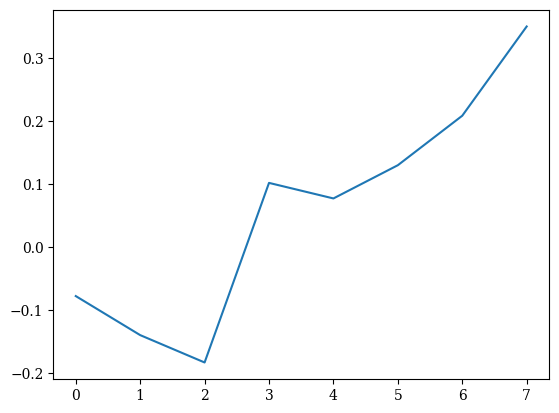

In [70]:
plt.plot(np.array(amp_avg['folding']['mean'])-np.array(amp_avg['extended']['mean']))

In [67]:
for experiment in ['extended', 'folding']:
    print(amp_avg[experiment]['mean'])

[0.6411387671309139, 0.7690427910324982, 0.7983428813581146, 0.6776485086611301, 0.6794260101541126, 0.7323816024076303, 0.683366950570064, 0.523744555717841]
[0.563395869697816, 0.6292471538579908, 0.6150464824473736, 0.7798127838456421, 0.7568669408054887, 0.8626498994737409, 0.89230537911631, 0.8745408008643987]


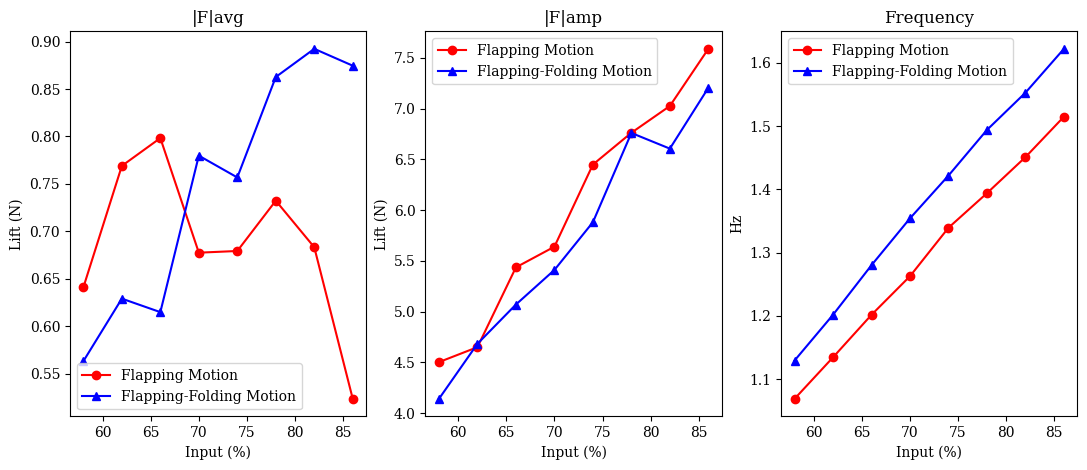

In [57]:
fig, axs = plt.subplots(1,3, figsize=(13, 5))
x = [58, 62, 66, 70, 74, 78, 82, 86]
calc = ['mean', 'amplitude', 'frequency']
name = {'mean': '|F|avg', 'amplitude': '|F|amp', 'frequency': 'Frequency'}
y_label = {'mean': 'Lift (N)', 'amplitude': 'Lift (N)', 'frequency': 'Hz'}
args = {'extended': ['Flapping Motion', 'red', 'o'], 'folding': ['Flapping-Folding Motion', 'blue', '^']}

for i, cal in enumerate(calc):
    for experiment in ['extended', 'folding']:
        axs[i].plot(x,amp_avg[experiment][cal], label=args[experiment][0], marker=args[experiment][2], color=args[experiment][1])

    axs[i].set_title(name[cal])
    axs[i].legend()
    axs[i].set_xlabel('Input (%)')
    axs[i].set_ylabel(y_label[cal])

#fig.show()
#fig.savefig('data/5deg_350motor/averages_lift_amp_freq.tif', dpi=600)


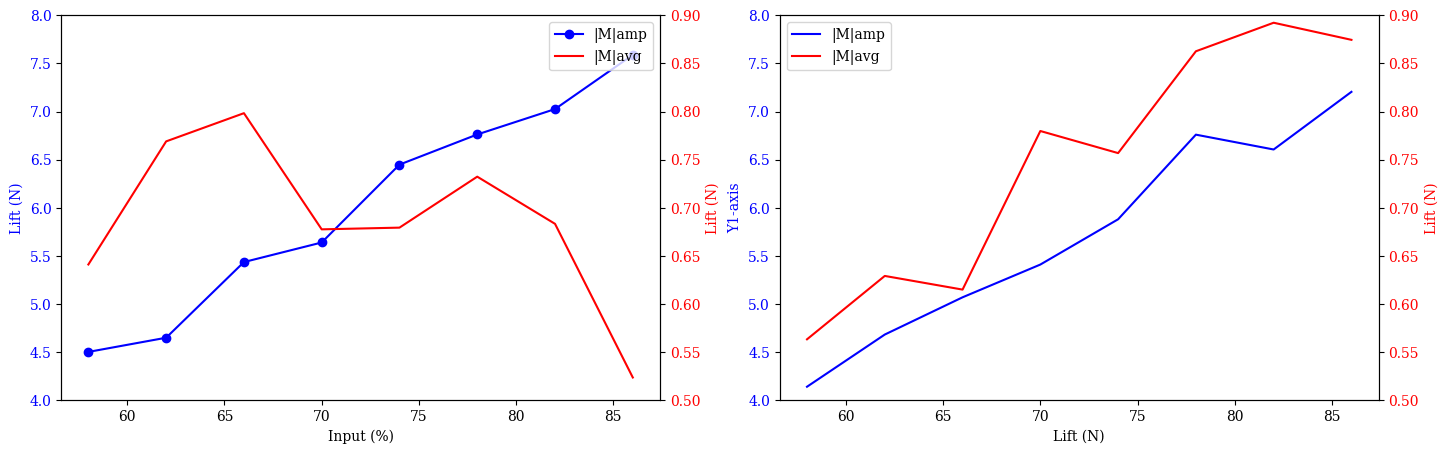

In [35]:
# Import Library

import numpy as np
import matplotlib.pyplot as plt

# Define Data

x = [58, 62, 66, 70, 74, 78, 82, 86]


# Create Plot
fig, ax1 = plt.subplots(1,2, figsize=(17, 5))
#######
data_1 = amp_avg['extended']['amplitude']
data_2 = amp_avg['extended']['mean']

ax1[0].set_xlabel('Input (%)')
ax1[0].set_ylabel('Lift (N)', color = 'blue')
ax1[0].set_ylim(4,8)
plot_1 = ax1[0].plot(x, data_1, marker='o', color = 'blue', label='|M|amp')
ax1[0].tick_params(axis ='y', labelcolor = 'blue')

ax2 = ax1[0].twinx()

ax2.set_ylabel('Lift (N)', color = 'red')
plot_2 = ax2.plot(x, data_2, color = 'red', label='|M|avg')
ax2.set_ylim(0.5,0.9)
ax2.tick_params(axis ='y', labelcolor = 'red')


lns = plot_1 + plot_2
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc=0)
######
data_1 = amp_avg['folding']['amplitude']
data_2 = amp_avg['folding']['mean']

ax1[1].set_xlabel('Lift (N)')
ax1[1].set_ylabel('Y1-axis', color = 'blue')
ax1[1].set_ylim(4,8)
plot_1 = ax1[1].plot(x, data_1, color = 'blue', label='|M|amp')
ax1[1].tick_params(axis ='y', labelcolor = 'blue')

ax2 = ax1[1].twinx()

ax2.set_ylabel('Lift (N)', color = 'red')
plot_2 = ax2.plot(x, data_2, color = 'red', label='|M|avg')
ax2.set_ylim(0.5,0.9)
ax2.tick_params(axis ='y', labelcolor = 'red')


lns = plot_1 + plot_2
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc=0)

# Show plot
plt.show()

6.766114543787892 0.8921038318043959


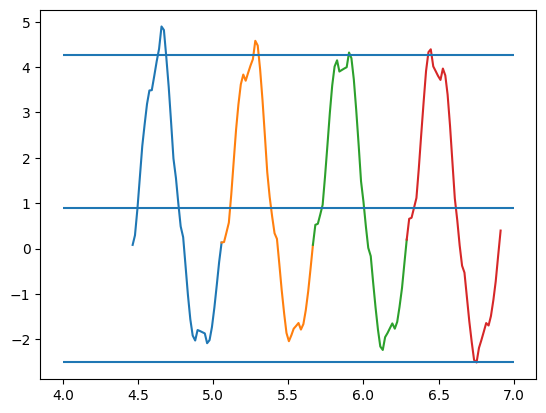

In [60]:
amp_avg[experiment] = {}
first = rect_start_end[0]
i=0
amplitudes = []
averages = []
while (rect_start_end[i+2]-first)<=3:
        start = rect_start_end[i]
        end =rect_start_end[i+2]
        stroke = df_sliced[(start<=df_sliced.timestamp)&(end>=df_sliced.timestamp)].copy()
        plt.plot(stroke.timestamp, stroke.lift)
        amplitudes.append(stroke.lift.max()-stroke.lift.min())
        averages.append(stroke.lift.mean())
        i += 2

mean = np.array(amplitudes).mean()
amplitude = np.array(amplitudes).mean()

amp_avg[experiment]['mean'].append(mean)
amp_avg[experiment]['amplitude'].append(amplitude)


In [242]:
for experiment_id in range(1,9):
    title = round(.5+.04*(experiment_id+1),2)
    fig = px.line(df[df.experiment_id == experiment_id], x='timestamp', y= 'lift', color='experiment', title=f'% from max: {title}  Volts: {round(title*12,2)}')# y=['thrust', 'lift'])
    fig.show()

# Analysis folding forces

In [ ]:
fig = px.scatter(df[(df.experiment_id ==8)&(df.experiment=='folding')], x='thrust', y='lift', animation_frame='timestamp')
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
fig.show()

In [ ]:
plt.plot(df[(df.experiment_id ==8)&(df.experiment=='folding')].thrust,df[(df.experiment_id ==8)&(df.experiment=='folding')].lift)
#plt.xlim(-0,0.4)
#plt.ylim(-0.1,0.3)
plt.hlines(0,-10,10)
